# Define the libraries

In [33]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta



# Define Function

In [34]:
def PlotData(Start,Duration,Mistake,Time,Data1,Data2,Figuur,player,arraystartsprint,arraystopsprint,StartError,StopError): 
    
    #Define starting en stopping positions for the CSV data
    Start = (Start-Mistake)*100
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    Timestamp = Time[Start:Stop]
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    Conv2 = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=1)
    DiffFrame = np.insert(DiffFrame,0,0)
    
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=1)
    DiffWheel = np.insert(DiffWheel,0,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    
    #Set all data into a datafram
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv','DiffFrame','DiffWheel'])
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4 and Rotate == False:
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4:
            Rotate = True
            Stop = False
        elif Stop == False:
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint),1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 3:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1 
                
    if str(StartError) == 'NaN':
        Startsprint = []
        Stopsprint = []
    elif len(Startsprint) == 0 and float(StartError) > 0:
        Startsprint = [StartError]
        Stopsprint = [StopError]
    elif float(StartError) > 0:
        for i in range(len(Startsprint)):
            Startsprint[i] = StartError
            Stopsprint[i] = StopError
    
    
    #Plot graph  
    fig, ax = plt.subplots(1,1)
    ax.plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')   
    
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax.axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax.axvline(x=Stop, color = 'm')
    ax.legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax.set_xlabel('Time (sec)')
    ax.set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(Start))
    
    ArrayStartSprint.append(Startsprint)
    ArrayStopSprint.append(Stopsprint)

# Visualize Data
## Define player and match

In [35]:
Player = 15
Game = 2

## Insert Data player

In [36]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Player

frAcc  frRoAcc  frDispl  frRoAng   frSpeed  timeLine  \
0       0.000000      0.0      0.0  0.00000  0.000000      0.01   
1       0.000000      0.0      0.0  0.00000  0.000000      0.02   
2       0.000000      0.0      0.0  0.00000  0.000000      0.03   
3       0.000000      0.0      0.0  0.00000  0.000000      0.04   
4       0.000000      0.0      0.0  0.00000  0.000000      0.05   
...          ...      ...      ...      ...       ...       ...   
860405 -0.002098   6556.8  -1946.6 -0.18538 -0.000787   8604.10   
860406 -0.026347   6556.8  -1946.6 -0.18939 -0.000808   8604.10   
860407  0.012933   6556.8  -1946.6 -0.23979 -0.001071   8604.10   
860408       NaN      NaN      NaN      NaN       NaN       NaN   
860409       NaN      NaN      NaN      NaN       NaN       NaN   

        frameRotationalSpeedX  frameRotationalSpeedY  frameRotationalSpeedZ  \
0                         NaN                    NaN                    NaN   
1                         NaN                    NaN                    NaN   
2                         NaN                    NaN                    NaN   
3                         NaN                    NaN                    NaN   
4                         NaN                    NaN                    NaN   
...                       ...                    ...                    ...   
860405                 1.0500                0.85556                -1.0500   
860406                 1.0920                0.93100                -1.0710   
860407                 1.1690                0.95900                -1.1200   
860408                 1.1433                0.93333                -1.0967   
860409                 1.1900                0.94500                -1.0850   

        wheelRotationalSpeedX  wheelRotationalSpeedY  wheelRotationalSpeedZ  \
0                         NaN                    NaN                    NaN   
1                         NaN                    NaN                    NaN   
2                         NaN                    NaN                    NaN   
3                         NaN                    NaN                    NaN   
4                         NaN                    NaN                    NaN   
...                       ...                    ...                    ...   
860405                 1.4000                1.16670                -1.5867   
860406                 1.4000                1.09200                -1.6240   
860407                 1.4000                1.08110                -1.5089   
860408                 1.4000                1.08500                -1.4700   
860409                 1.4389                0.97222                -1.5089   

        frRoSpeed  
0         0.00000  
1         0.00000  
2         0.00000  
3         0.00000  
4         0.00000  
...           ...  
860405   -0.40135  
860406   -5.03910  
860407        NaN  
860408        NaN  
860409        NaN  

[860410 rows x 13 columns]

## Define boundaries
### Get Timestamps from CSV

In [37]:
df_Timestamps = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_FoundSprints.csv')
Timestamps = df_Timestamps['Time'].to_numpy()
len(Timestamps)

156

# Fix Error things

In [38]:
StartError = [
              343.8,736,2114.2,2125.5,2137.2,0,2198,'NaN',2234,2266.5,'NaN',2310.8,2351,2374.9,2395.5,2620,2645.3,2672.2,2687,2697.5,2752,2773,2808.5,2823,2841,2866.5,2899.5,2956.7,3001,3119.5,3208,3317,3398,3407,3600.5,3623.5,0,3654,0,3728.5,3767.8,3798,3836.6,3850,3956.3,0,0,3969,4013.5,'NaN',4032,4053,
              4108,4120,'NaN',0,4168.5,'NaN',4216.5,4223.5,'NaN',4285.5,0,4326,'NaN',4933,'NaN','NaN',4955,'NaN','NaN',4997.5,'NaN',5057,'NaN',0,
              5121,5146,5181,5184,5195,5217,5239,5256.5,5374.5,0,5439.5,5451,'NaN',5474.5,5522,0,6208,'NaN',6237,'NaN',6264.5,'NaN',6282,6308
              ,'NaN',6352.5,6372,6383,'NaN',6490,6512,0,6536.5,6547,6575.5,6600.5,'NaN',6627.5,0,6677,0,6872,6887,6914,'NaN',7008.5,0,7065,7065,'NaN',7084.5,7144,7199,7229,7244,7375.5,7469,'NaN',0,0,7520.5,'NaN','NaN',7729,7766,7772.5,7782.5,0,7803,7811,7841,7899.5,7925.5,0,7948,0,7974.5,7986,8010.5,0,
             ]

StopError =  [
              347,738,2121.5,2128.8,2143,0,2203,'NaN',2236,2270,'NaN',2314,2354,2377,2399,2621.5,2649,2674.5,2691,2700.5,2755,2779,2812,2828,2845,2869.5,2902.5,2962,3006.8,3123.3,3211.8,3321,3401,3411,3604,3626,0,3659,0,3735,3774.8,3804,3842.4,3854,3962,0,0,3974,4019,'NaN',4042,4058.5,
              4113,4124,'NaN',0,4172,'NaN',4220.5,4226.4,'NaN',4288,0,4328.5,'NaN',4935.5,'NaN','NaN',4960,'NaN','NaN',5006,'NaN',5061,'NaN',0,
              5124,5151.5,5183,5188,5200,5220.5,5241.5,5258,5379,0,5443,5457.5,'NaN',5477,5526,0,6212,'NaN',6240,'NaN',6268,'NaN',6285.5,6310.5
             ,'NaN',6357,6378,6390,'NaN',6494,6517,0,6543,6551,6578,6604,'NaN',6633,0,6682,0,6877,6890.5,6918,'NaN',7012,0,7068.5,7068.5,'NaN',7087,7146,7202,7232,7248,7380,7471,'NaN',0,0,7522.5,'NaN','NaN',7731,7770,7774.5,7787,0,7808,7813,7837.5,7904,7930,0,7951,0,7980,7991,8016.5,0
            ]
len(StartError)

156

### Visualize

<ipython-input-34-69a0fbf6054f>:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


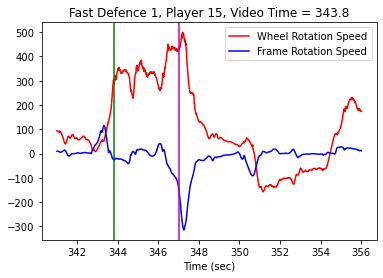

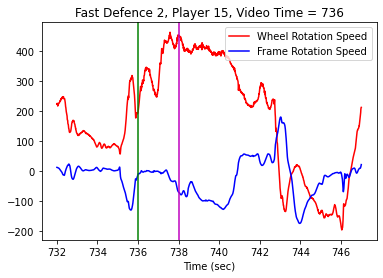

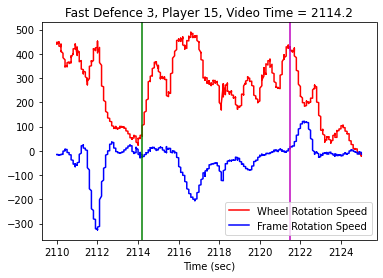

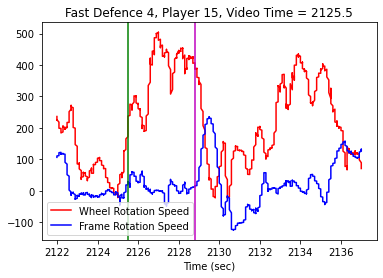

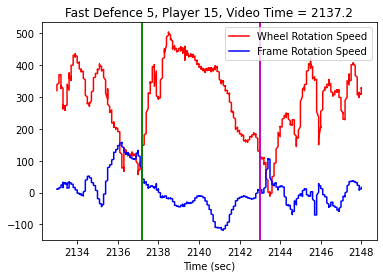

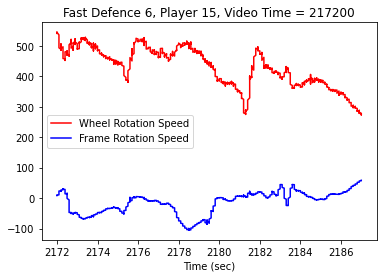

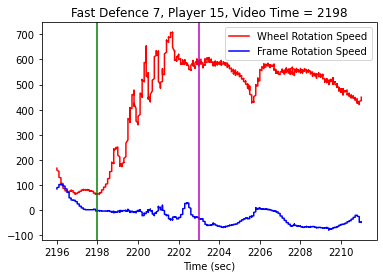

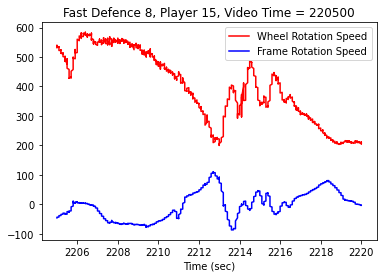

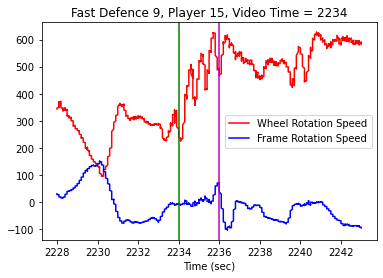

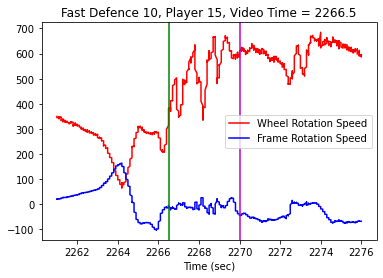

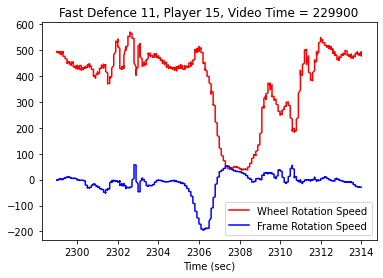

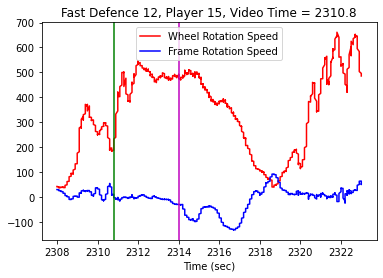

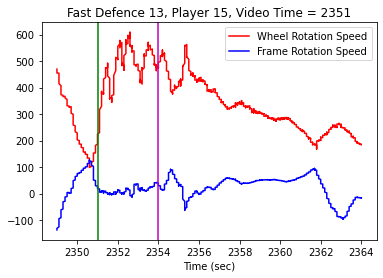

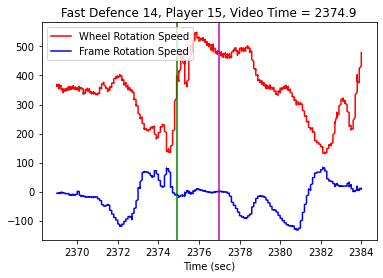

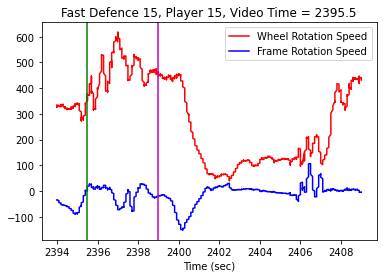

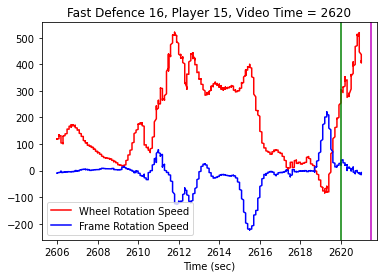

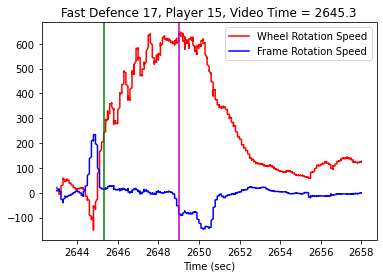

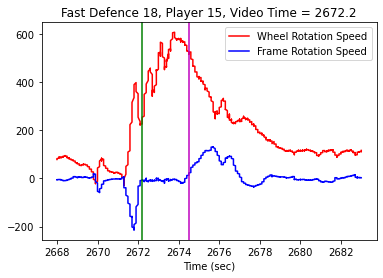

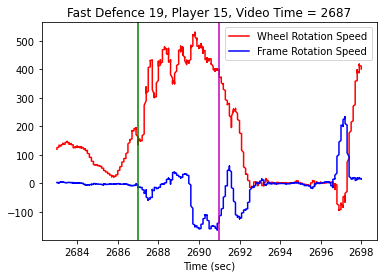

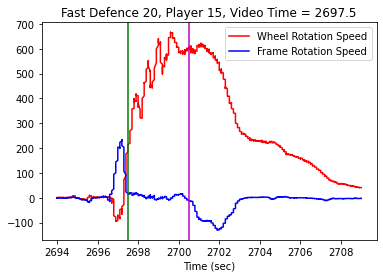

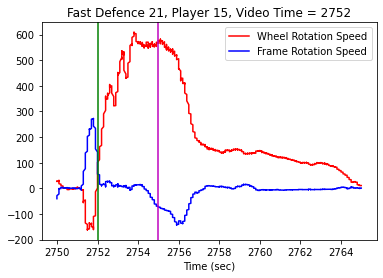

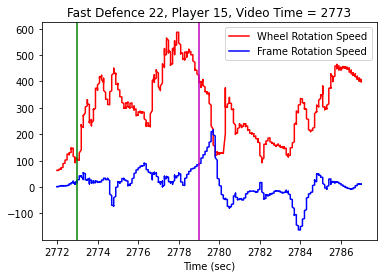

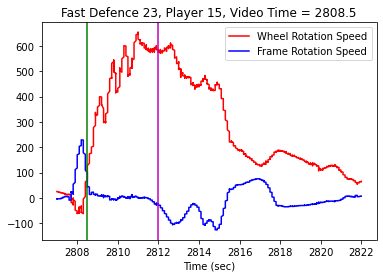

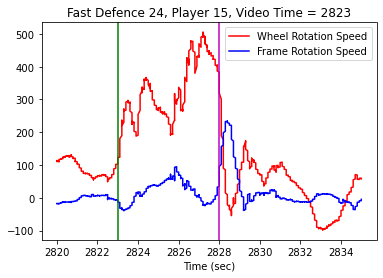

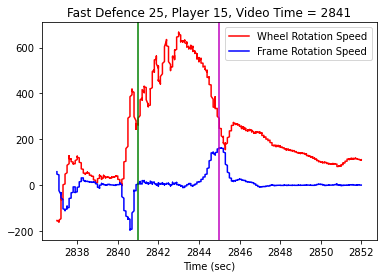

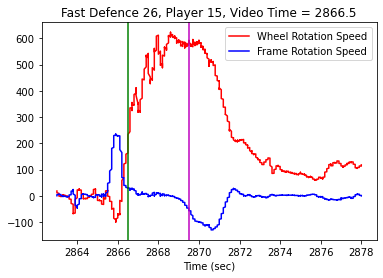

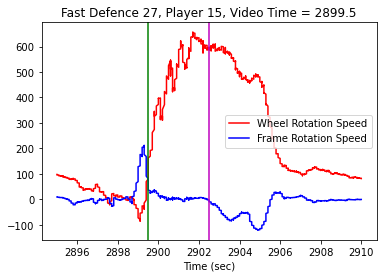

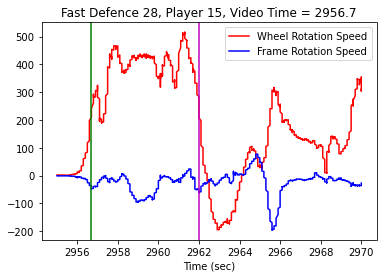

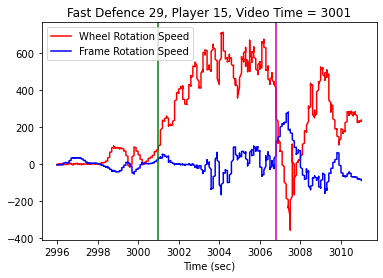

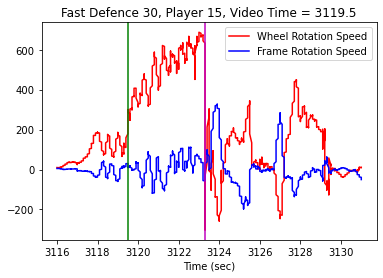

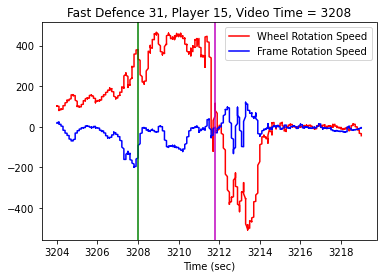

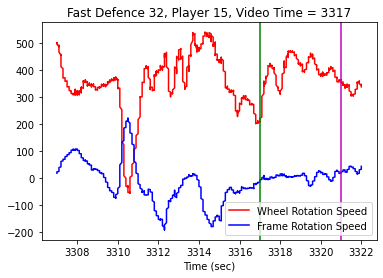

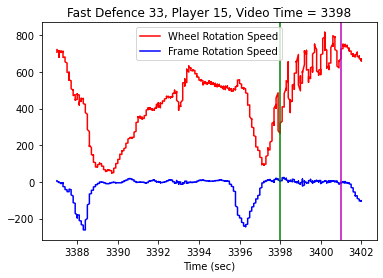

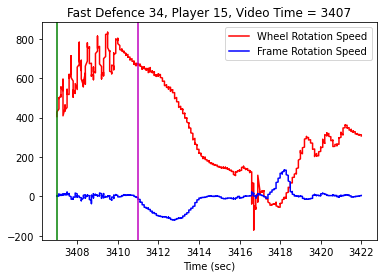

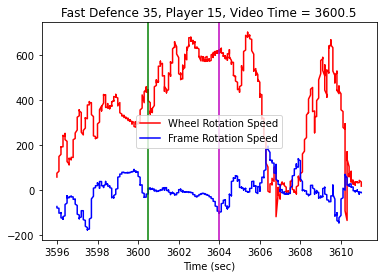

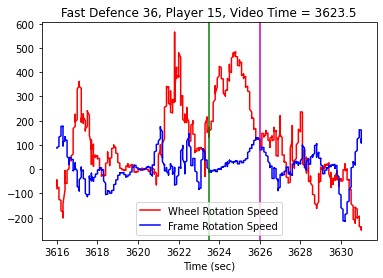

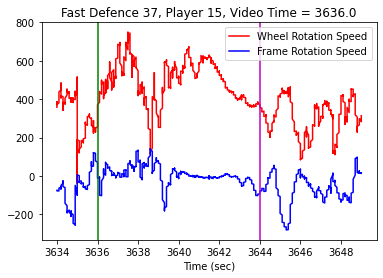

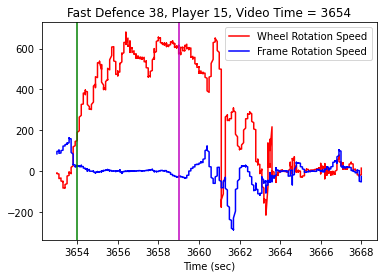

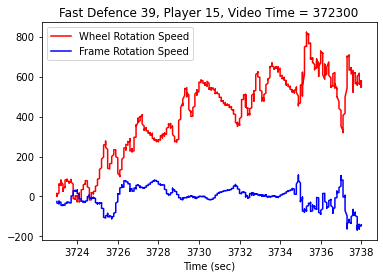

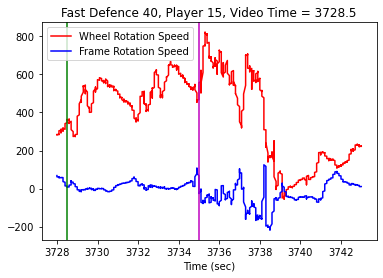

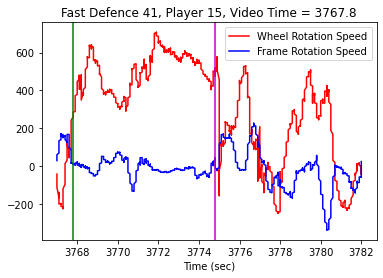

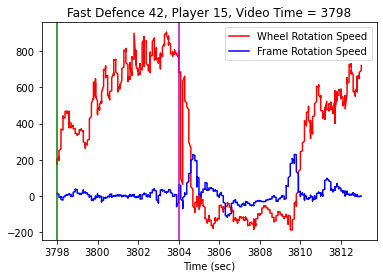

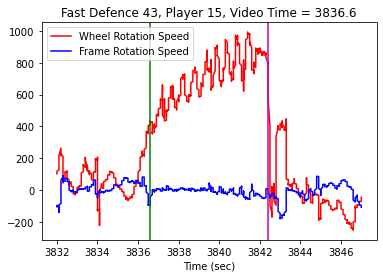

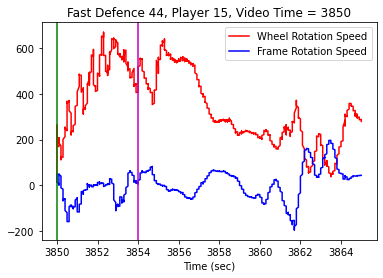

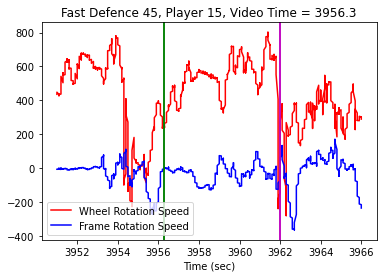

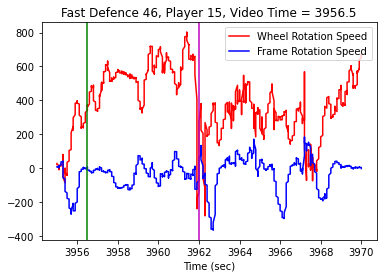

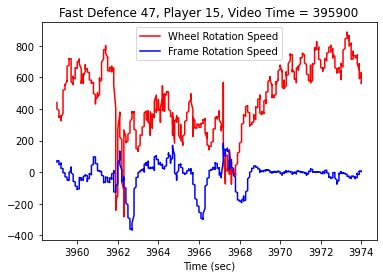

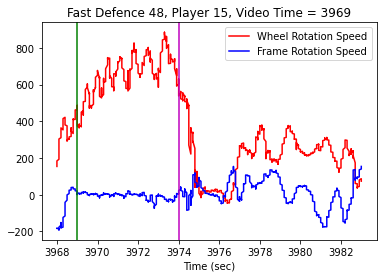

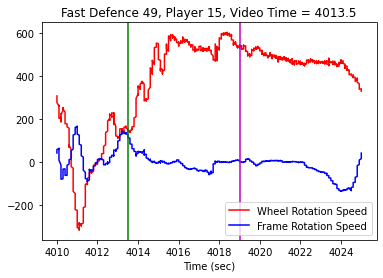

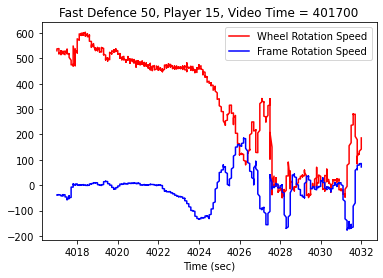

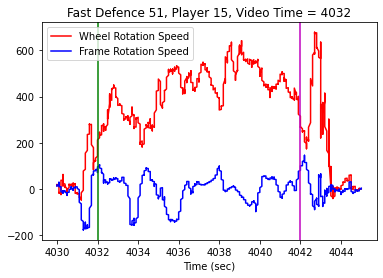

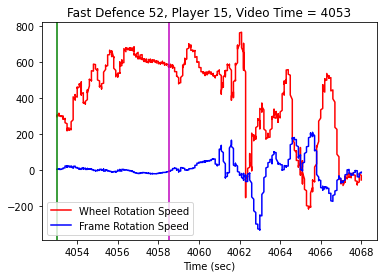

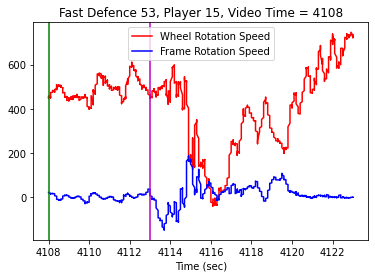

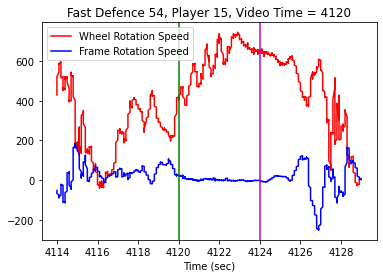

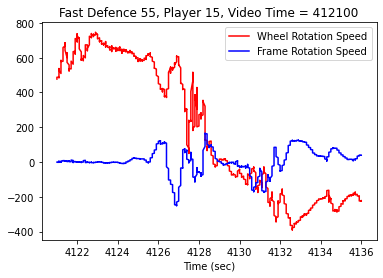

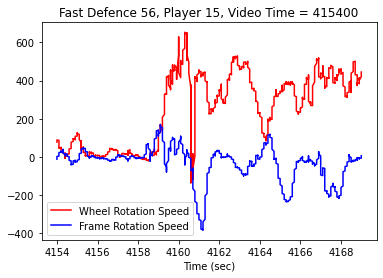

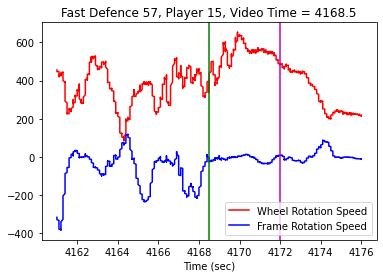

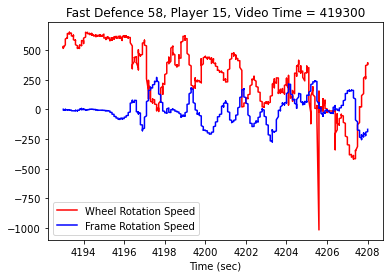

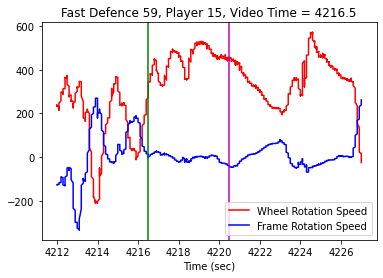

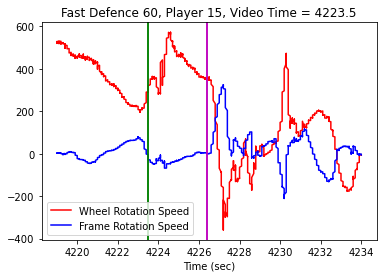

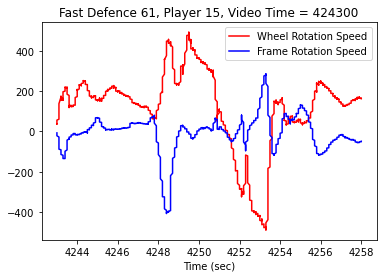

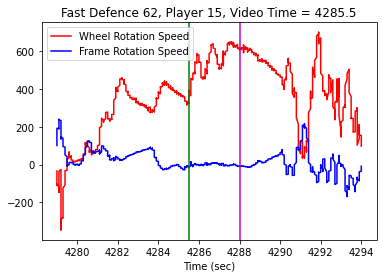

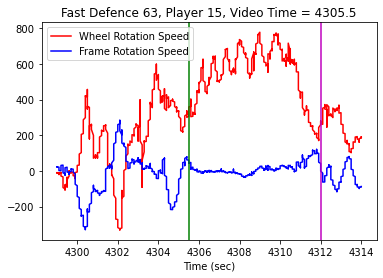

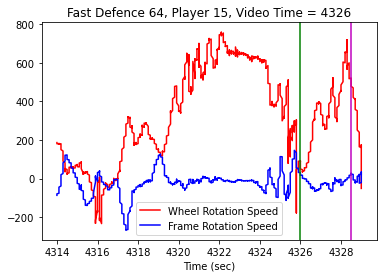

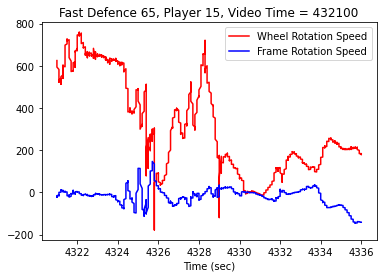

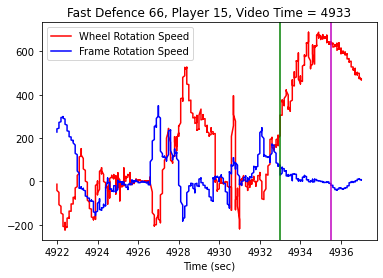

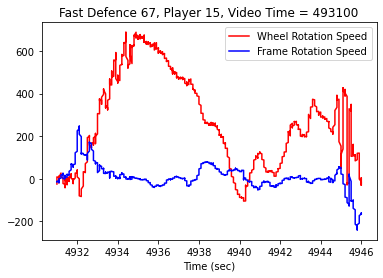

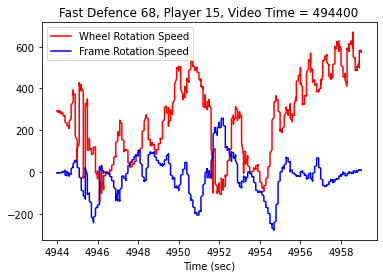

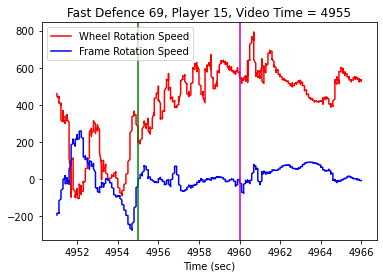

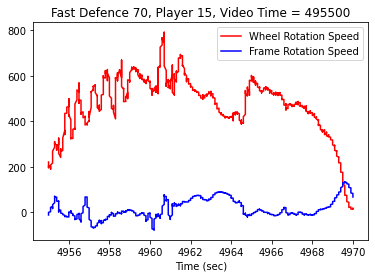

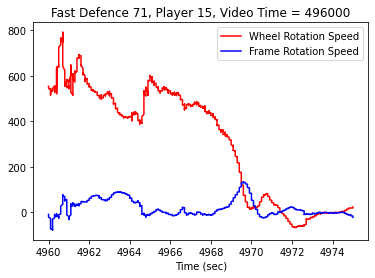

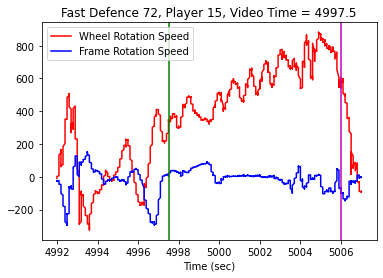

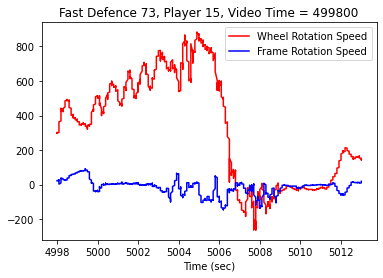

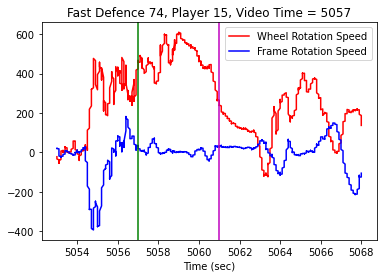

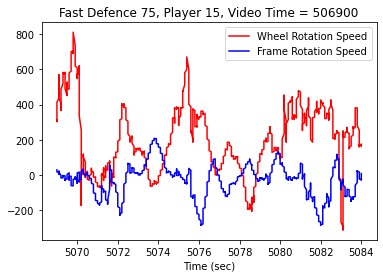

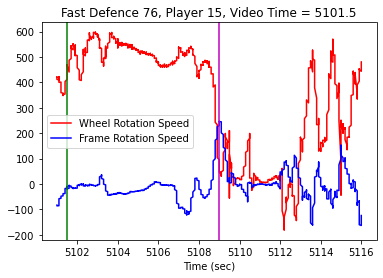

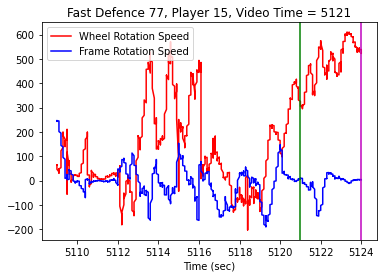

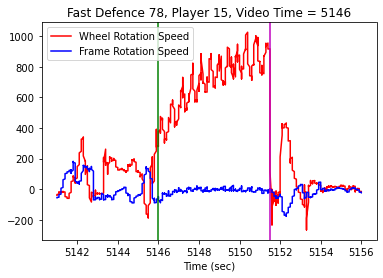

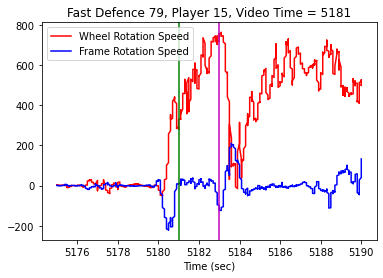

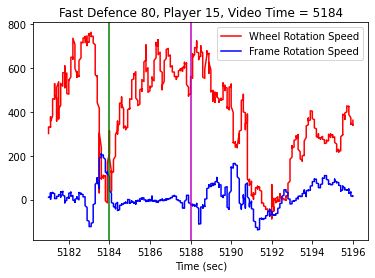

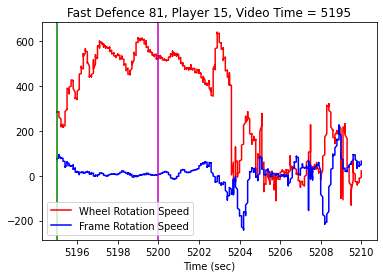

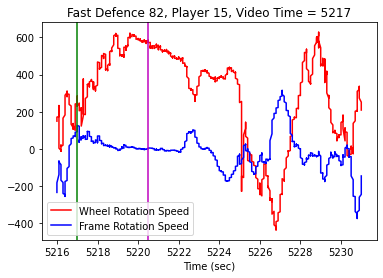

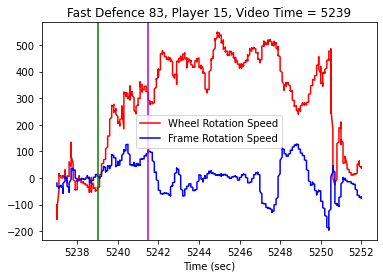

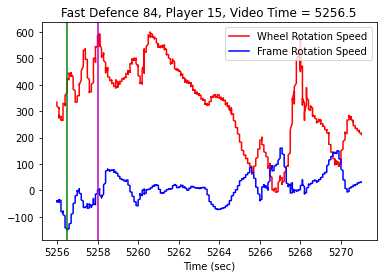

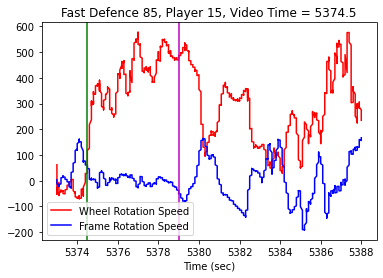

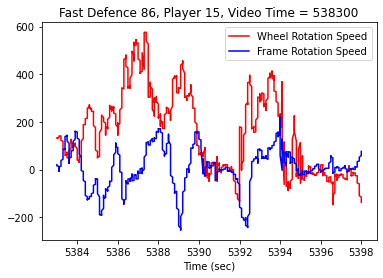

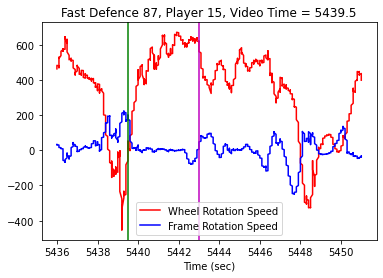

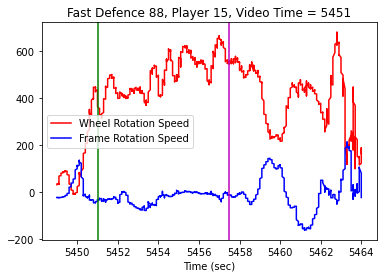

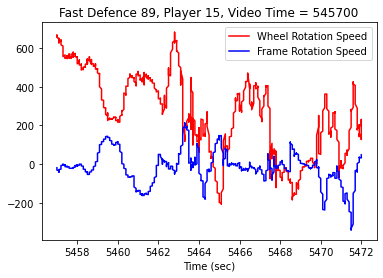

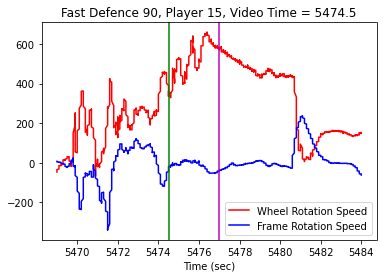

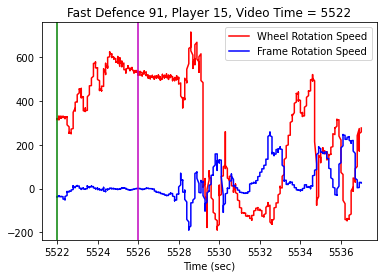

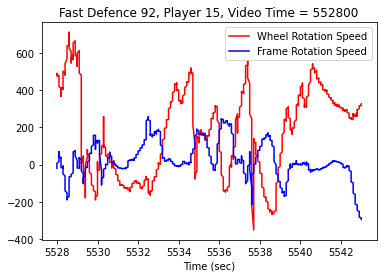

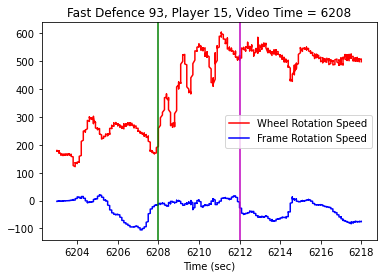

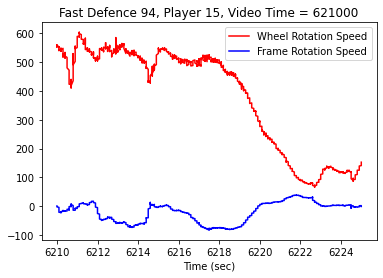

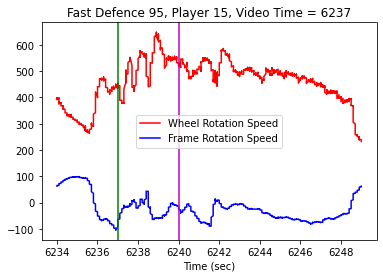

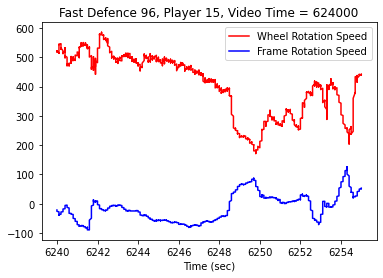

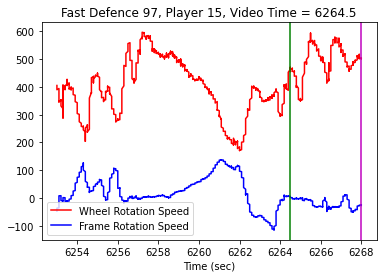

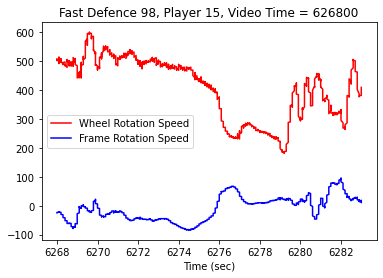

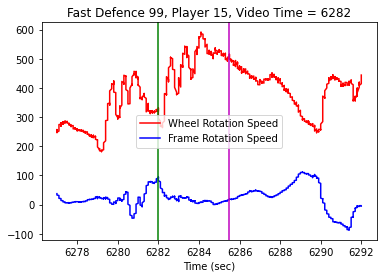

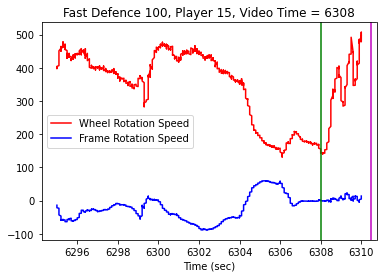

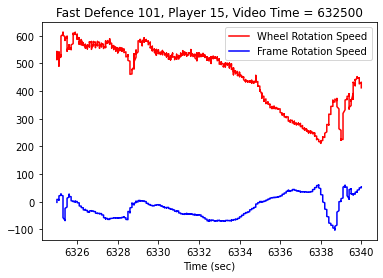

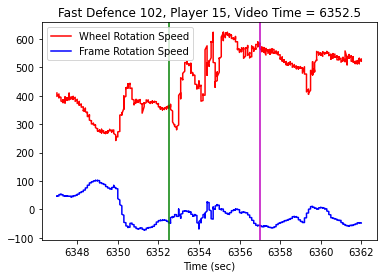

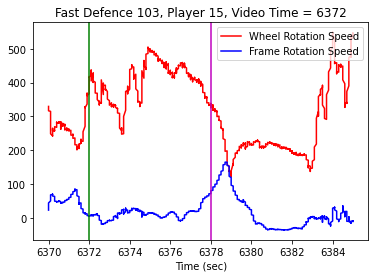

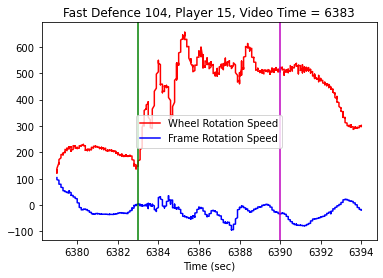

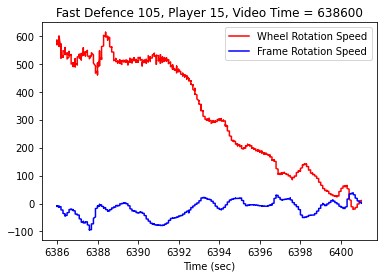

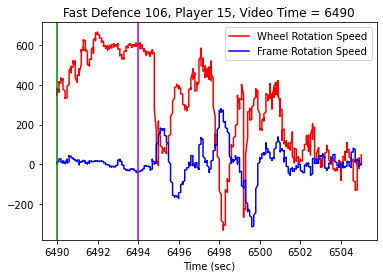

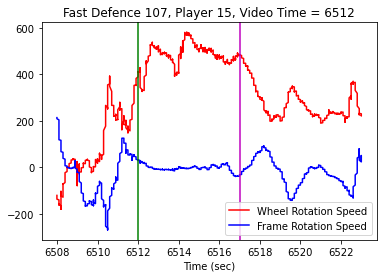

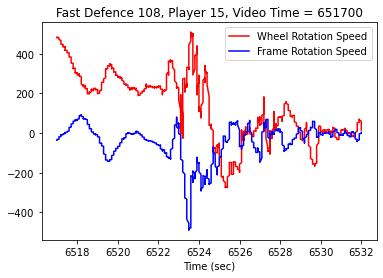

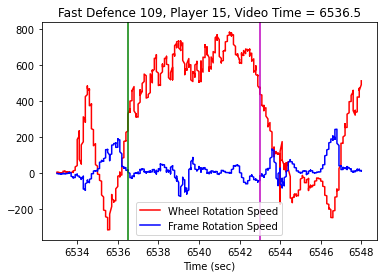

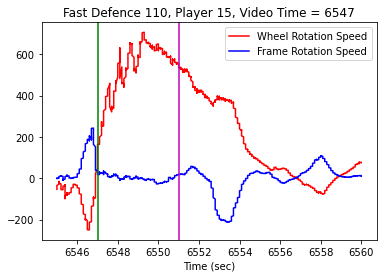

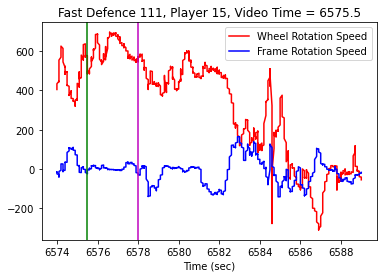

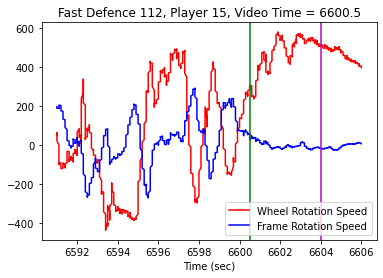

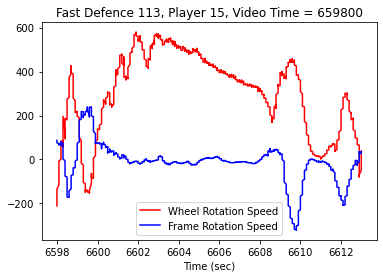

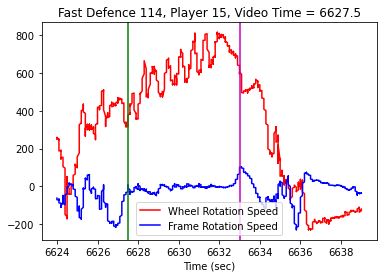

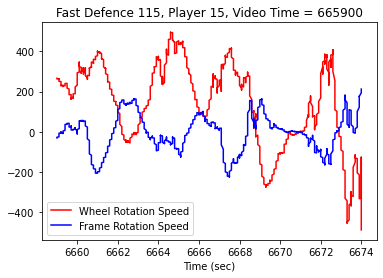

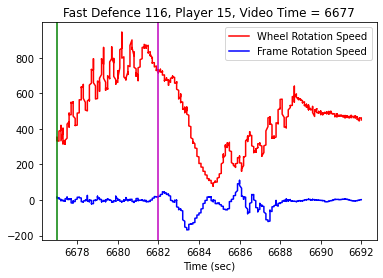

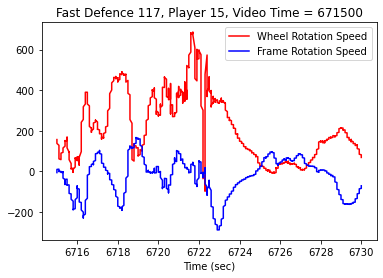

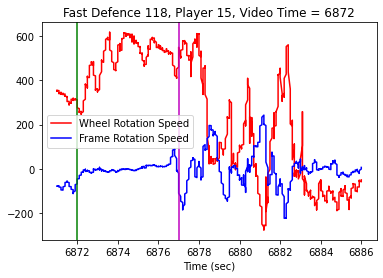

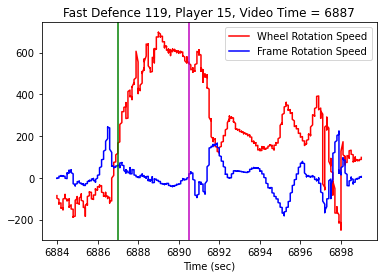

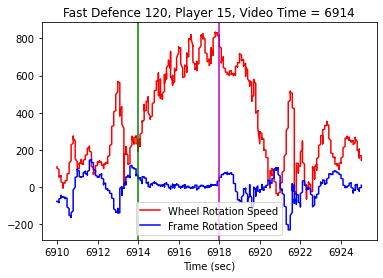

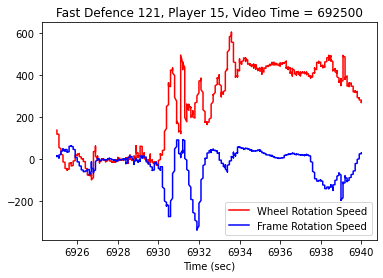

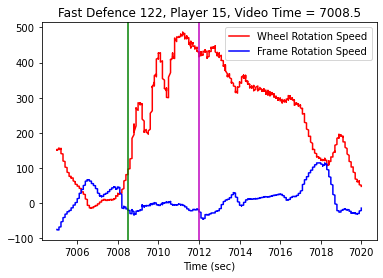

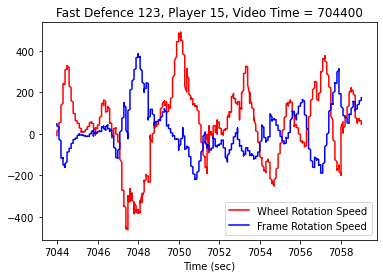

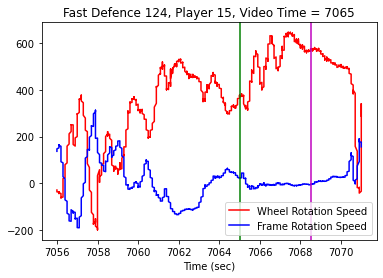

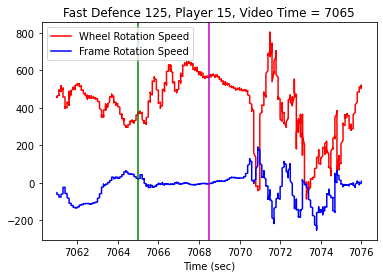

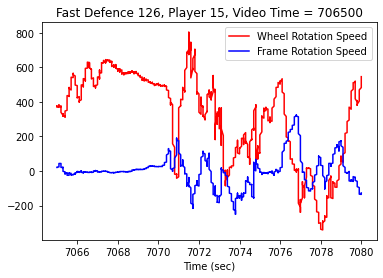

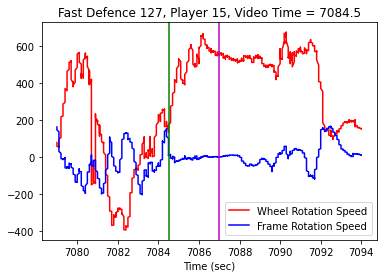

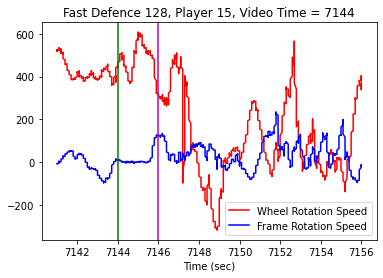

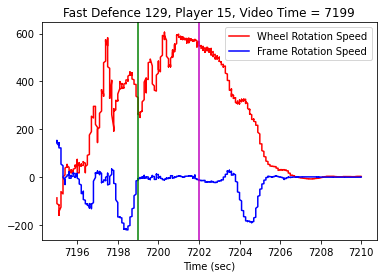

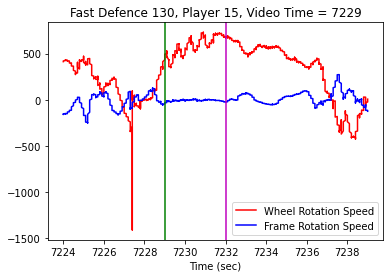

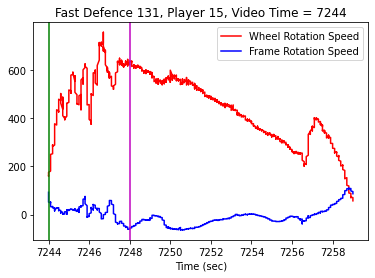

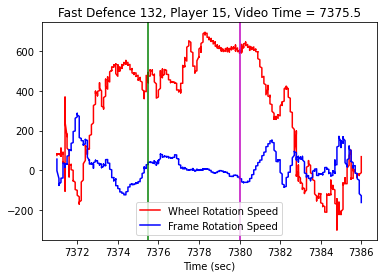

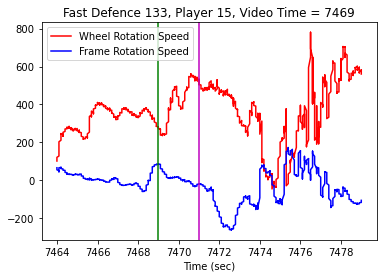

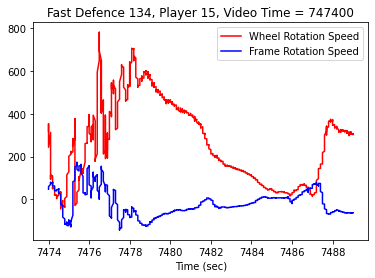

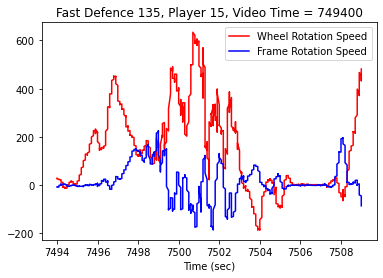

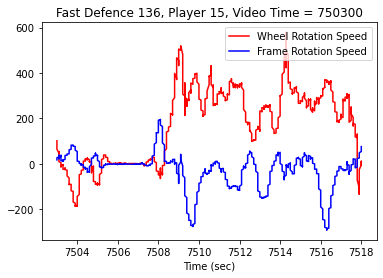

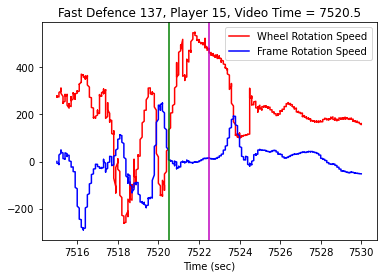

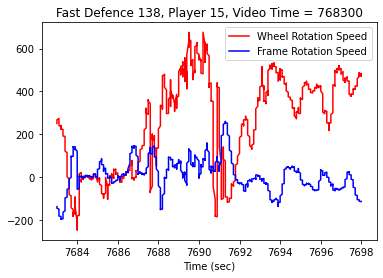

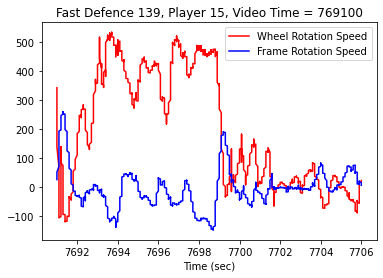

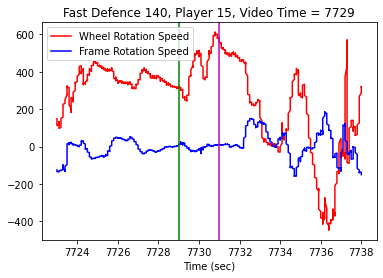

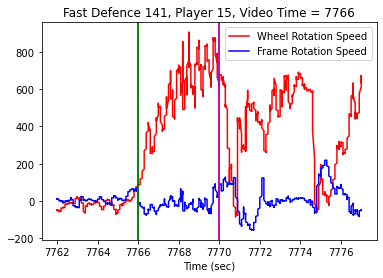

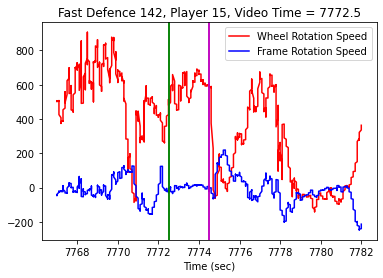

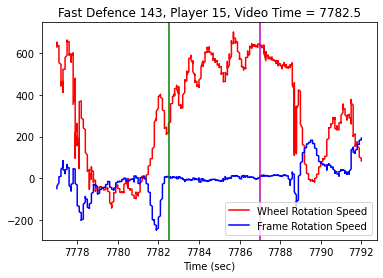

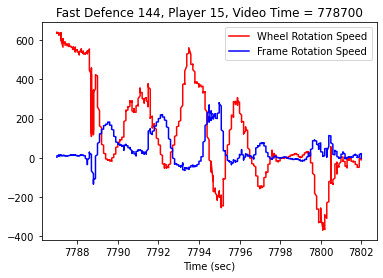

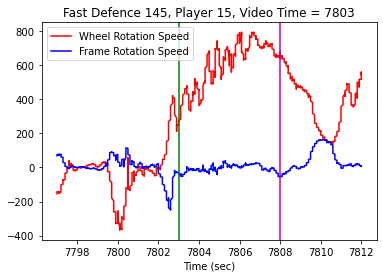

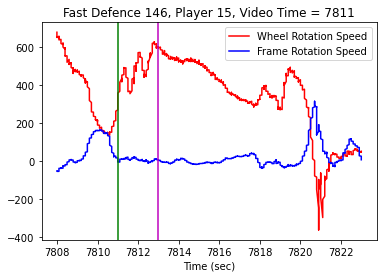

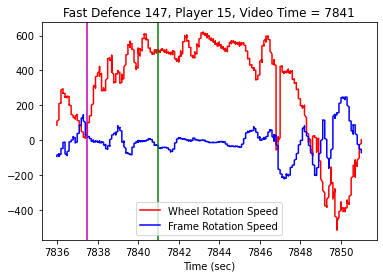

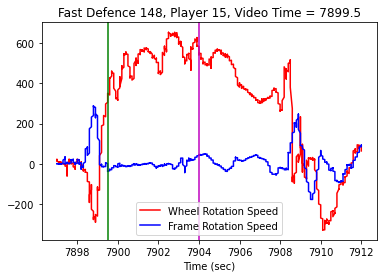

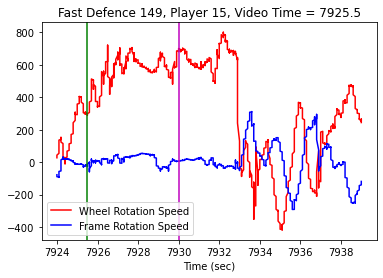

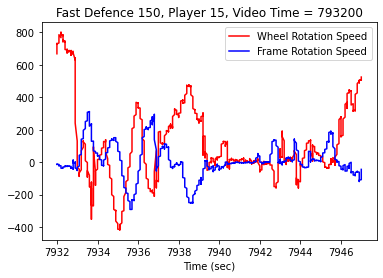

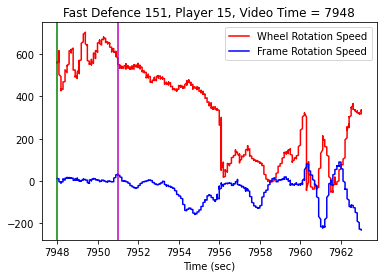

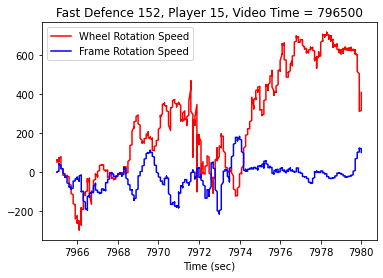

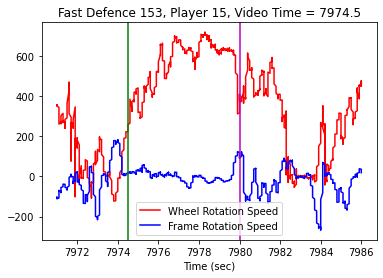

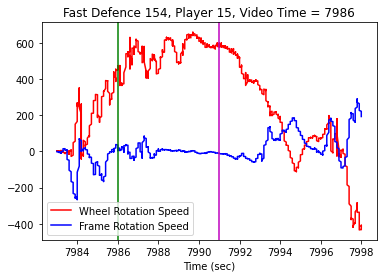

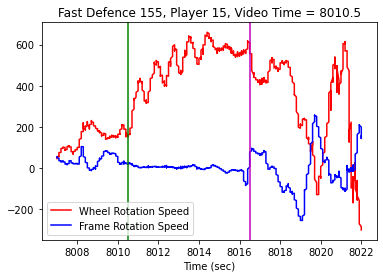

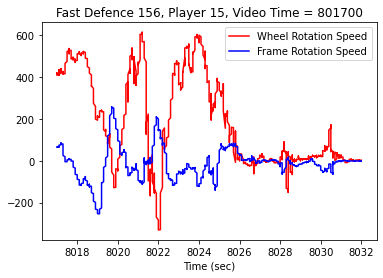

In [39]:
ArrayStartSprint = []
ArrayStopSprint = []
for i in range(0,len(Timestamps),1):
     PlotData(Timestamps[i], 15,5, df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),ArrayStartSprint, ArrayStopSprint,StartError[i],StopError[i])

In [41]:
Startsprint =[]
Stopsprint = []

df_Filter = df_Player
df_Filter = df_Filter.fillna(0)

Order = 5 
cutoff_freq = 1.5
sampling_freq = 100
sampling_duration = len(df_Filter.wheelRotationalSpeedX)/100

  
normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)

filtered_WheelRotationspeedX = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.wheelRotationalSpeedX)
filtered_FrameRotationspeedZ = signal.lfilter(numerator_coeffs, denominator_coeffs, df_Filter.frameRotationalSpeedZ)


df_Player['Sum_WheelX_FrameZ']  = df_Player.wheelRotationalSpeedX + df_Player.frameRotationalSpeedZ
df_Player['Div_FrameZ_WheelX']  = df_Player.frameRotationalSpeedZ / df_Player.wheelRotationalSpeedX
df_Player['Filt_WheelX'] = filtered_WheelRotationspeedX
df_Player['Filt_FrameZ'] = filtered_FrameRotationspeedZ

for start in ArrayStartSprint:
    for time in start:
        Startsprint.append(time)

for stop in ArrayStopSprint:
    for time in stop:
        Stopsprint.append(time)
        
df_Player_Action = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Action.csv')

df_Player['Action'] = df_Player_Action['Action']
        
for i  in range(0,len(Startsprint)):
    df_Player['Action'].iloc[int(Startsprint[i]*100):int(Stopsprint[i]*100)] = 1
        
df_Player.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

